In [1]:
%matplotlib inline

import matplotlib
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from numpy.linalg import norm
from scipy.integrate import solve_ivp
from scipy.spatial.distance import pdist,squareform

In [2]:
class Plasma:
    def __init__(self,nparticles=10,temperature=1.,electron_mass_ratio=1./3.):
        self.n = int(nparticles)
        self.Temp = temperature
        # phase-space coordinates (2n,4) with x,y,vx,vy
        # uniform random position and gaussian velocity
        # first half is ions, second half is electrons
        self.y = np.concatenate((np.random.rand(2*self.n,2),self.Temp*np.random.randn(2*self.n,2)),axis=1)
        
        # charge ion, charge electron
        self.q = np.append(np.ones(self.n),-np.ones(self.n))
         # mass ion, mass electron
        self.m = np.append(np.ones(self.n),electron_mass_ratio*np.ones(self.n))
        
        #
        self.G=0.03  # coulomb coupling
        self.t=0.    # time
        
        # for calculating the force
        self.chrgmat=self.q.reshape((1, -1,1))*self.q.reshape((-1, 1,1))
        self.mssmat=np.asarray([self.m,self.m]).T
        # for calculating the potentiel energy
        self.chrgcoup=self.q.reshape((1,-1))*self.q.reshape((-1,1))
        np.fill_diagonal(self.chrgcoup,0.)
        self.chrgcoup=squareform(self.chrgcoup)
    
    
    def backinbox(self):
        ## put back in periodic box
        # self.y[:,:2]%=1.
        
        ## mirror off wall
        crossed_x1 = self.y[:,0] < 0
        crossed_x2 = self.y[:,0] > 1
        crossed_y1 = self.y[:,1] < 0
        crossed_y2 = self.y[:,1] > 1

        self.y[crossed_x1,0] *= -1.
        self.y[crossed_x2,0] = 2.-self.y[crossed_x2,0]
        self.y[crossed_y1,1] *= -1. 
        self.y[crossed_y2,1] = 2.-self.y[crossed_y2,1]
        # mirror velocity
        self.y[crossed_x1 | crossed_x2, 2] *= -1.
        self.y[crossed_y1 | crossed_y2, 3] *= -1.

        
    def kinerg(self):
        return 0.5*np.sum(self.m*np.sum(self.y[:,2:]**2,axis=1))
    
    def poterg(self):
        return self.G*np.sum(self.chrgcoup/pdist(self.y[:,:2]))
    
    def toterg(self):
        return self.kinerg()+self.poterg()
    
    def push(self,dt):
        stepper=solve_ivp(self.accel,(self.t,self.t+dt),self.y.flatten(),rtol=1.e-6)
        self.y=stepper.y[:,-1].reshape(-1,4)
        self.t=stepper.t[-1]
         
        ## Euler
        #stepper=dt*self.accel(0.,self.y.flatten())
        #self.y+=stepper.reshape(-1,4) # magic command to recover the data in x,y,vx,vy
        #self.t+=dt  
        
        self.backinbox()
        
    def accel(self,time,y):
        ytmp=y.reshape(-1,4) # magic command to recover the data in x,y,vx,vy
        acc=np.concatenate((ytmp[:,2:],self.force(ytmp[:,:2])/self.mssmat),axis=1)
        return acc.flatten()
    
    def force(self,pos):
        # 2d displacement matrix
        disps=pos.reshape((1,-1,2))-pos.reshape((-1,1,2))
        # distance array
        dists=norm(disps,axis=2)
        dists[dists==0]=1.  # Avoid divide by zero warnings
        # Coulomb force array
        return -self.G*(disps*self.chrgmat/np.expand_dims(dists,2)**3).sum(axis=1)
        
    def get_electrons(self):
        return self.y[self.n:,0],self.y[self.n:,1]
    
    def get_ions(self):
        return self.y[:self.n,0],self.y[:self.n,1]
        
    def plot_electrons(self):
        x,y=self.get_electrons()
        plt.plot(x,y,'.r',label='electrons')
    
    def plot_ions(self):
        x,y=self.get_ions()
        plt.plot(x,y,'.b',label='ions')
           
    def plot(self):
        self.plot_ions()
        self.plot_electrons()
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.gca().set_aspect('equal', adjustable='box')

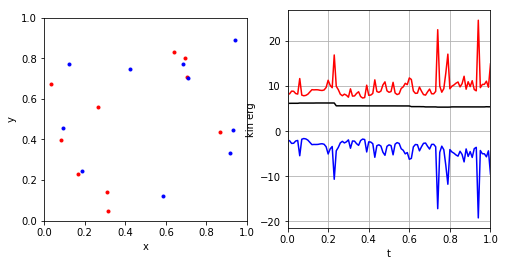

In [4]:
plas=Plasma(10)
dt=1.e-2
tfin=1.

fig,(axp,axr) = plt.subplots(1,2,figsize=(8,4))
axp.set_xlim(0, 1)
axp.set_ylim(0, 1)
axp.set_aspect('equal', adjustable='box')
axp.set_xlabel('x')
axp.set_ylabel('y')

axr.set_xlim(0,tfin)
axr.set_autoscale_on
axr.set_xlabel('t')
axr.set_ylabel('kin erg')
axr.grid()
elec, = axp.plot([],[],'.r')
ions, = axp.plot([],[],'.b')
kin,  = axr.plot([],[],'-r')
pot,  = axr.plot([],[],'-b')
erg,  = axr.plot([],[],'-k')

def init():
    elec.set_data([],[])
    ions.set_data([],[])
    kin.set_data([],[])
    pot.set_data([],[])
    erg.set_data([],[])
    
    return elec,ions,kin,pot,erg

def animate(i):
    global dt, axp, axr, fig, plas
    
    #subsampling
    plas.push(dt)
        
    x,y=plas.get_electrons()
    elec.set_data(x,y)
    x,y=plas.get_ions()
    ions.set_data(x,y)
  
    erg.set_xdata(np.append(erg.get_xdata(),plas.t))
    erg.set_ydata(np.append(erg.get_ydata(),plas.toterg()))
    
    kin.set_xdata(np.append(kin.get_xdata(),plas.t))
    kin.set_ydata(np.append(kin.get_ydata(),plas.kinerg()))
    
    pot.set_xdata(np.append(pot.get_xdata(),plas.t))
    pot.set_ydata(np.append(pot.get_ydata(),plas.poterg()))
        
    axr.relim()
    axr.autoscale_view()

    return elec,ions,kin,pot,erg

ani = anim.FuncAnimation(fig,animate,frames=int(tfin/dt),interval=10,blit=True,init_func=init)

ani.save('plasma_box.mp4',fps=30,extra_args=['-vcodec','libx264'])
    
plt.show()